This is an example of a jupyter notebook, running using the `pixi` environment we created to manage our dependencies. Note that you may need to change your python interpreter (top right corner) to:
`.pixi/envs/default/bin/python`

In [1]:
# disable gpu to test on CPU-only
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import os
import glob
import re
import pandas as pd
import numpy as np
import random
import torch
import sklearn

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

from sklearn.metrics import roc_auc_score
import bioacoustics_model_zoo as bmz
from opensoundscape.ml.shallow_classifier import quick_fit 

2025-03-28 22:24:04.596688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Pre-processing

In [3]:
import requests
import zipfile
import os

url = "https://storage.googleapis.com/dse-staff-public/data.zip"
dest_path = "."

# Create destination directory if it doesn't exist
os.makedirs(dest_path, exist_ok=True)

# Download the ZIP file
response = requests.get(url, stream=True)
with open(os.path.join(dest_path, "data.zip"), 'wb') as f:
    for chunk in response.iter_content(chunk_size=1024): 
        if chunk: 
            f.write(chunk)

# Unzip the file
with zipfile.ZipFile(os.path.join(dest_path, "data.zip"), 'r') as zip_ref:
    zip_ref.extractall(dest_path)

In [4]:
datapath = "data/audio" # should use relative paths.
species = "bullfrog"
datatype = "data"

files = glob.glob(os.path.join(datapath, species, datatype, "**/*.wav"), recursive=True)
labels = pd.DataFrame({"file": files, "present": ["pos" in f.lower() for f in files]})

# Do this step ONLY to convert to 5 second dataset to run perch!!!!
labels['file'] = labels['file'].apply(lambda x: re.sub(r'data', 'data_5s', x, count=2).replace('data_5s', 'data', 1)) 

labels['file'] = labels['file'].astype(str)
labels.set_index("file", inplace=True)

pd.set_option('display.max_colwidth', 100)
print(labels.head())

                                                                present
file                                                                   
data/audio/bullfrog/data_5s/neg/bullfrog-neg-t-11113588_12.wav    False
data/audio/bullfrog/data_5s/neg/bullfrog-neg-t-11113588_5.wav     False
data/audio/bullfrog/data_5s/neg/bullfrog-neg-t-11113588_15.wav    False
data/audio/bullfrog/data_5s/neg/bullfrog-neg-t-11113588_4.wav     False
data/audio/bullfrog/data_5s/neg/bullfrog-neg-t-11113588_14.wav    False


In [5]:
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[['present']])

Run Models

In [6]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [7]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo', "Perch", trust_repo=True)

Using cache found in /home/jovyan/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main
/opt/conda/lib/python3.12/site-packages/tensorflow_hub/__init__.py:61: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/opt/conda/lib/python3.12/site-packages/opensoundscape/ml/cnn.py:599: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered strin

In [8]:
emb_train = model.embed(labels_train, return_dfs=False, batch_size=128, num_workers=0)
emb_val = model.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

model.change_classes(['present'])

/opt/conda/lib/python3.12/site-packages/opensoundscape/utils.py:349: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
/opt/conda/lib/python3.12/site-packages/opensoundscape/utils.py:349: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
/opt/conda/lib/python3.12/site-packages/opensoundscape/utils.py:349: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[l

  0%|          | 0/1 [00:00<?, ?it/s]

I0000 00:00:1743200652.274237     192 service.cc:148] XLA service 0x64a3d66aa3a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743200652.274269     192 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-03-28 22:24:12.478555: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1743200652.485518     192 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1743200654.321824     192 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-28 22:24:14.327891: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339401216 exceeds 10% of free system memory.
/opt/conda/lib/python3.12/site-packages/opensoundscape/utils.py:349: FutureWarning: Series.__ge

  0%|          | 0/1 [00:00<?, ?it/s]

W0000 00:00:1743200656.733690     192 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert


In the prior step is where the kernel crashes while embedding, apparently could be caused by a package installation issue with tensorflow or numpy (https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes) 

Error: "The Kernel crashed while executing code in the current cell or a previous cell. Please review the code in the cell(s) to identify a possible cause of the failure."

In [9]:
quick_fit(model.network, emb_train, labels_train.values, emb_val, labels_val.values, steps=1000)

Epoch 100/1000, Loss: 0.20836235582828522, Val Loss: 0.24200448393821716
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 0.09886069595813751, Val Loss: 0.12468123435974121
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 0.05829340219497681, Val Loss: 0.07854687422513962
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 0.03886823356151581, Val Loss: 0.055060021579265594
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 0.02799311839044094, Val Loss: 0.041265591979026794
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 0.02124089188873768, Val Loss: 0.03236822783946991
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 0.016731975600123405, Val Loss: 0.026236359030008316
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 0.013554942794144154, Val Loss: 0.021797506138682365
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 0.011222404427826405, Val Loss: 0.018460331484675407
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 0.0094534689560

In [10]:
predictions = model.network(torch.tensor(emb_val).float()).detach().numpy()
score = roc_auc_score(labels_val.values, predictions, average=None)

print(score)

1.0


/opt/conda/lib/python3.12/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


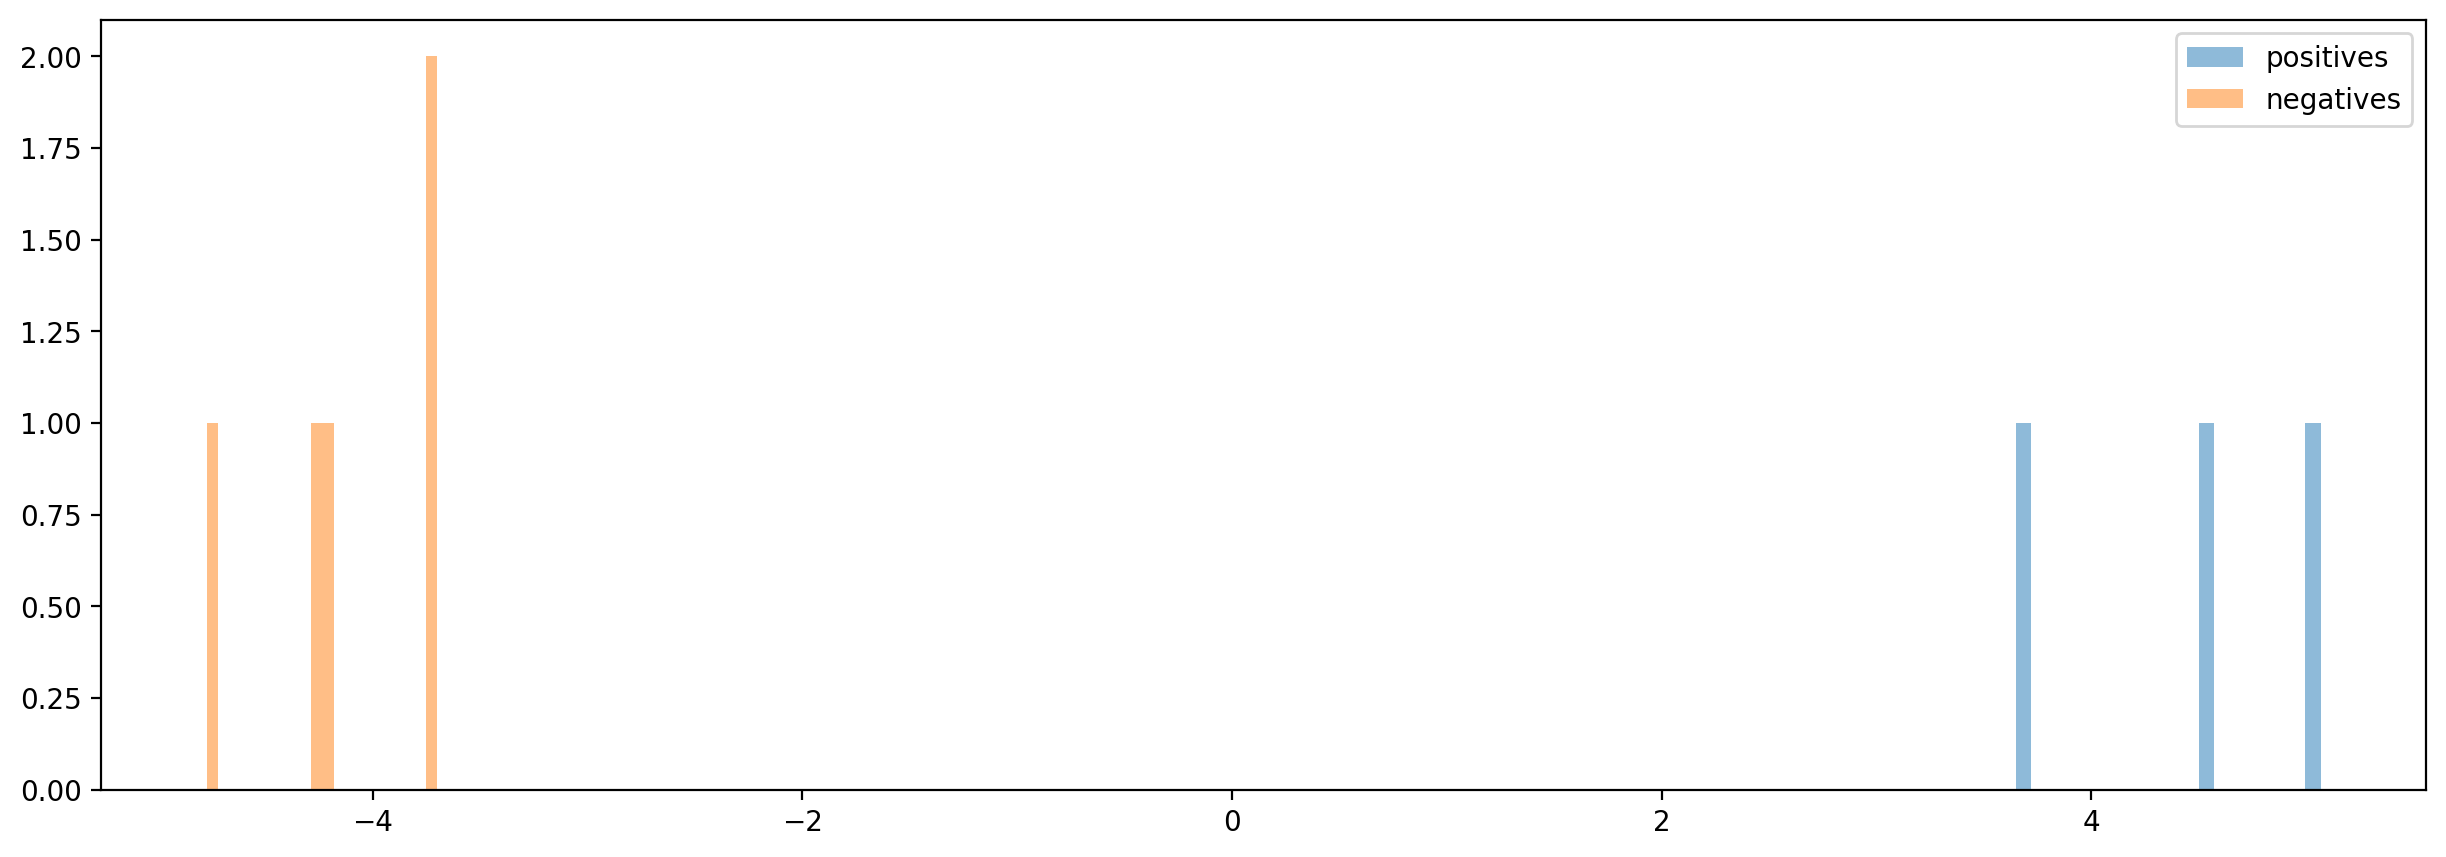

In [11]:
plt.hist(predictions[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(predictions[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()